In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')

import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu
import shapely
from tqdm import tqdm, tqdm_notebook
import ast, shutil

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchshow as ts
from DataSetImagePresence import DataSetImagePresence
import loadpaths_pecl
path_dict_pecl = loadpaths_pecl.loadpaths()

Font size is set to 10


In [55]:
# model_name_full = 'PECL-ImEn_2024-10-01-1358_vnum-64.data'
# model_name_full = 'PECL-ImEn_2024-10-03-1832_vnum-91.data'
vnum = 195
# model_path_checkpoint = '/home/tplas/models/PECL/lightning_logs/version_64/checkpoints/best_checkpoint_val-epoch=15-val_loss=4.31-train_loss=3.81.ckpt'

In [56]:
## Load dataset

filepath_train_val_split = os.path.join(path_dict_pecl['repo'], 'content/split_indices_s2bms_2024-08-14-1459.pth')
image_folder=None
presence_csv=None
n_cpus=4
dataset_name = 's2bms'

## Load model

load_model_method = 'from_checkpoint' # 'from_checkpoint' or 'from_full_model', 'from_imagenet', 'from_scratch'
if load_model_method == 'from_full_model':
    model = pem.load_model(filename=model_name_full, verbose=0)
    batch_size = model.batch_size_used
elif load_model_method == 'from_checkpoint':
    model = pem.load_model_from_ckpt(v_num=vnum)
    batch_size = model.batch_size_used
elif load_model_method == 'from_imagenet':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet='imagenet')
    batch_size=64
elif load_model_method == 'from_seco':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet='seco')
    batch_size=64
elif load_model_method == 'from_scratch':
    model = pem.ImageEncoder(n_enc_channels=256, n_layers_mlp_pred=1,
                             pretrained_resnet=False)
    batch_size=64
else:
    raise ValueError('Not implemented')

model.eval()
model.to('cpu')

## Load data:

# 


image_folder = path_dict_pecl[f'{dataset_name}_images']
presence_csv = path_dict_pecl[f'{dataset_name}_presence']
ds = DataSetImagePresence(image_folder=image_folder, presence_csv=presence_csv,
                            shuffle_order_data=True, species_process='all',
                            augment_image=True, dataset_name=dataset_name,
                            zscore_im=True, mode='train')
train_ds, val_ds, test_ds = ds.split_into_train_val(filepath=filepath_train_val_split)
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=n_cpus, 
                        shuffle=True, persistent_workers=True, #drop_last=True, pin_memory=True
                        pin_memory=False, prefetch_factor=2)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=n_cpus, 
                    shuffle=False,  persistent_workers=True,
                    pin_memory=False) 
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=n_cpus, 
                        shuffle=False,  persistent_workers=True)
print(len(train_ds), len(val_ds), len(test_ds))
print(f'\n\n----\n v_num: {vnum}  seed: {model.seed_used}, batch size: {model.batch_size_used}, knn: {model.pecl_knn}, temp: {model.temperature}, k_bottom {model.k_bottom} \n----\n\n')

Using dropout.
No class weights.
Loaded Resnet18 with random weights.
Freezing all but last layer: False, last layer: False.
Freezing prediction model: True.
Found 1329 out of 1455 images in the image folder.
Shuffling data.


/home/tplas/repos/PECL/notebooks/../scripts/DataSetImagePresence.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_indices = torch.load(filepath)


947 196 186


----
 v_num: 195  seed: 17, batch size: 256, knn: 5, temp: 1, k_bottom 32 
----




In [62]:
batch = next(iter(test_dl))
im, pres_vec = batch
print(im.shape, pres_vec.shape)

im_enc = model(im)
print(im_enc.shape)

def cosine_sim(a, b):
    return F.cosine_similarity(a, b, dim=-1)

def cosine_sim_self(a):
    assert len(a.shape) == 2, a.shape
    n_samples, n_features = a.shape
    a_norm = F.normalize(a, p=2, dim=1)
    sim = torch.mm(a_norm, a_norm.t())
    assert sim.shape == (n_samples, n_samples)
    return sim

sim_im_enc = cosine_sim_self(im_enc)
sim_presence = cosine_sim_self(pres_vec)
assert sim_im_enc.shape == sim_presence.shape, (sim_im_enc.shape, sim_presence.shape)

sim_im_enc = sim_im_enc.cpu().detach().numpy()
sim_presence = sim_presence.cpu().detach().numpy()

torch.Size([186, 4, 224, 224]) torch.Size([186, 62])
torch.Size([186, 256])


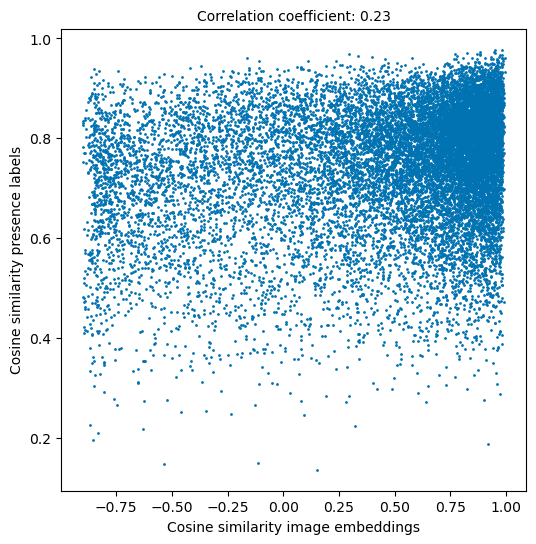

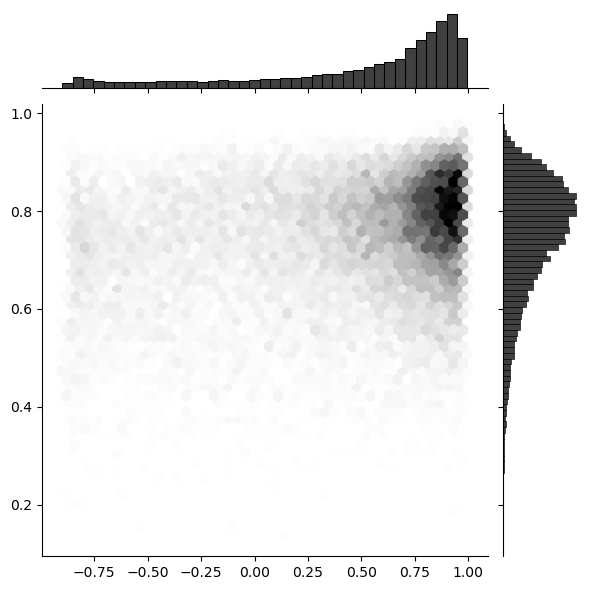

In [63]:
# ts.show(sim_im_enc), ts.show(sim_presence)
## scatter plot upper triangle of similarity matrices
n_samples = sim_im_enc.shape[0]
sim_im_enc_plot = sim_im_enc[np.triu_indices(n_samples, k=1)]
sim_presence_plot = sim_presence[np.triu_indices(n_samples, k=1)]
assert sim_im_enc_plot.shape == sim_presence_plot.shape

plt.figure(figsize=(6,6))
plt.scatter(sim_im_enc_plot, sim_presence_plot, s=1)
plt.xlabel('Cosine similarity image embeddings')
plt.ylabel('Cosine similarity presence labels')
corr_coef = np.corrcoef(sim_im_enc_plot, sim_presence_plot)[0,1]
plt.title(f'Correlation coefficient: {corr_coef:.2f}')

import seaborn as sns
sns.jointplot(x=sim_im_enc_plot, y=sim_presence_plot, kind='hex', color='k')

In [10]:
flatten_dist = False 
temperature = 1
pecl_knn = None
pecl_knn_hard_labels = False


dist_array_ims = pem.normalised_softmax_distance_batch(im_enc, flatten=flatten_dist, temperature=temperature,
                                                       exclude_diag_in_denominator=True,
                                                       inner_prod_only=False)
dist_array_pres = pem.normalised_softmax_distance_batch(pres_vec, flatten=flatten_dist, knn=pecl_knn,
                                                    knn_hard_labels=pecl_knn_hard_labels,
                                                    temperature=temperature,
                                                    similarity_function='cosine',
                                                    soft_weights_squared=True,  # only matters if hard labels is False
                                                    inner_prod_only=True)

tmp_ims = dist_array_ims
tmp_pres = dist_array_pres                                                    
inds_one = torch.where(dist_array_pres > 0)
if True:
    dist_array_pres = dist_array_pres[inds_one]
    assert (dist_array_pres > 0).any(), (dist_array_pres, im_enc.shape, pres_vec.shape, dist_array_ims.shape, dist_array_ims)
    assert len(dist_array_pres) == batch_size * pecl_knn
    dist_array_ims = dist_array_ims[inds_one]
    assert (dist_array_ims >= 0).all(), (dist_array_ims, im_enc)
    assert (dist_array_ims <= 1.01).all(), (dist_array_ims, im_enc)
    assert (dist_array_pres >= 0).all(), (dist_array_pres, im_enc, pres_vec)
    assert (dist_array_pres <= 1.01).all(), (dist_array_pres, pres_vec, torch.where(dist_array_pres > 1), dist_array_pres[torch.where(dist_array_pres > 1)])  # changed to 1.01 because of numerical issues when vals = 1.000
    loss = (-1 * torch.log(dist_array_ims + 1e-8) * dist_array_pres).mean()
    assert loss >= 0, loss
    print(loss)

AssertionError: Expecting inds_bottom_normalise to be set.

In [87]:
# torch.topk(tmp_pres, k=2, dim=1, largest=False)[1].shape
with torch.no_grad():
    tmp = torch.stack([tmp_ims[i, inds[i]].sum() for i in range(inds.shape[0])]).clone()
tmp

tensor([0.4666, 0.6153, 0.8807, 0.6509, 0.9328, 0.8174, 0.9962, 0.7144, 0.7031,
        0.9605, 1.0160, 0.6096, 0.7225, 0.9444, 0.7751, 0.7447, 0.5796, 0.7295,
        0.4540, 1.0149, 0.8333, 0.8215, 0.8890, 0.9662, 0.6206, 0.6184, 0.5760,
        0.5958, 0.9370, 0.6291, 0.7484, 0.8318, 0.6313, 0.9420, 0.7739, 0.9312,
        0.8112, 0.7983, 0.7958, 0.4907, 0.7221, 0.9267, 0.5985, 0.5837, 0.5435,
        0.8926, 0.9826, 0.9220, 0.5616, 0.7525, 0.8259, 0.9282, 0.6381, 0.5764,
        0.4601, 0.6459, 0.8110, 0.5827, 0.8158, 0.7863, 1.0768, 0.8233, 0.7004,
        0.8866, 0.8180, 0.8005, 0.6179, 0.7022, 0.7687, 1.1832, 0.7364, 0.6781,
        0.6208, 0.5151, 0.7264, 0.7703, 0.5912, 0.3945, 0.5970, 0.9298, 0.8809,
        0.4961, 0.5890, 0.6820, 0.7508, 0.5554, 0.6349, 0.7757, 0.6361, 0.6985,
        0.7151, 0.7839, 0.6179, 1.0739, 0.6913, 0.7495, 0.7733, 0.6910, 0.7747,
        0.7588, 0.7678, 0.8370, 0.4172, 0.6026, 0.7981, 0.3809, 0.7730, 0.8496,
        1.0516, 0.8014, 0.9391, 0.8060, 

In [61]:
tmp = torch.topk(tmp_pres, k=10, dim=1, largest=False)
# tmp_pres[tmp[1]].shape
print(tmp[0].shape, tmp[1].shape, tmp_pres.shape)

inds = tmp[1]
tmp_ims_row_sum = [tmp_ims[i, inds[i]].sum() for i in range(inds.shape[0])]
# tmp_ims_row_sum
tmp[1]
# tmp_ims_selected = torch.zeros_like(tmp_ims)
# for i in range(inds.shape[0]):
#     tmp_ims_selected[i, inds[i]] = tmp_ims[i, inds[i]]
# tmp_ims_selected

torch.Size([186, 10]) torch.Size([186, 10]) torch.Size([186, 186])


tensor([[156,  87,  52,  ..., 131,  83,  30],
        [156,  52,  87,  ..., 107, 166, 131],
        [ 34,  92,   7,  ...,  99,  17,  60],
        ...,
        [ 34,  92, 138,  ...,  60, 154, 131],
        [131,  70,  15,  ..., 138, 124, 112],
        [156,  52, 107,  ..., 158, 150,  87]])

In [116]:
k_bottom = 5
sum_inner_prod_mat = torch.topk(tmp_ims, k=k_bottom, dim=1, largest=False)[0].sum(1)
sum_inner_prod_mat = sum_inner_prod_mat + 1e-8  # avoid division by zero
# inner_prod_mat = tmp_ims / sum_inner_prod_mat[:, None]

sum_inner_prod_mat

tensor([2.4554, 3.3445, 3.4046, 3.5636, 2.9013, 3.2818, 2.2761, 3.9693, 2.5675,
        3.2445, 2.8502, 2.6669, 4.5810, 3.2536, 2.9843, 3.1285, 4.3215, 3.3367,
        3.3748, 3.6750, 2.7169, 2.7395, 3.1100, 2.8937, 3.1413, 2.8400, 3.7174,
        3.1682, 2.5929, 2.4042, 4.0122, 3.4791, 2.5453, 3.6335, 3.3107, 3.2423,
        3.0204, 3.4800, 2.6101, 2.4335, 3.0761, 2.6431, 3.0493, 3.3923, 3.6688,
        2.7624, 3.0538, 2.9464, 2.9338, 2.9050, 3.4270, 2.8297, 3.1081, 3.4318,
        3.0288, 4.5822, 3.5079, 2.7449, 3.0996, 3.2015, 3.1575, 3.4664, 3.3066,
        3.7139], grad_fn=<AddBackward0>)

In [120]:
sum_inner_prod_mat[:, None] + tmp_ims

tensor([[5.1737, 3.3021, 3.1919,  ..., 3.2521, 3.8854, 3.3220],
        [4.1912, 6.0627, 4.5896,  ..., 4.3293, 4.6761, 4.8942],
        [4.1411, 4.6497, 6.1229,  ..., 5.7844, 5.0763, 5.5562],
        ...,
        [4.2631, 4.4512, 5.8462,  ..., 6.1846, 5.1812, 5.5268],
        [4.7367, 4.6383, 4.9783,  ..., 5.0215, 6.0249, 5.1161],
        [4.5805, 5.2636, 5.8655,  ..., 5.7743, 5.5233, 6.4322]],
       grad_fn=<AddBackward0>)

tensor([21.0748, 17.9085, 17.8690, 17.0850, 20.7752, 18.4939, 16.8366, 15.8101,
        17.7440, 19.4523, 21.7689, 18.3324, 13.0479, 14.1832, 20.1048, 20.7183,
        15.1723, 19.2625, 15.6308, 17.9433, 18.4849, 19.1860, 18.0453, 15.9817,
        20.4106, 15.8452, 16.5004, 20.2149, 21.3415, 17.8481, 13.9226, 18.0552,
        17.4922, 17.7974, 17.9436, 17.8440, 18.1542, 18.5708, 17.3396, 22.4742,
        19.7914, 19.2361, 20.3448, 19.4420, 17.6710, 21.4889, 19.9134, 18.5353,
        20.3659, 21.6211, 18.8123, 21.2139, 20.3010, 18.8371, 20.3906, 13.8351,
        18.6809, 16.5299, 17.8419, 18.1386, 17.1164, 17.0099, 19.3114, 17.6648],
       grad_fn=<SumBackward1>)

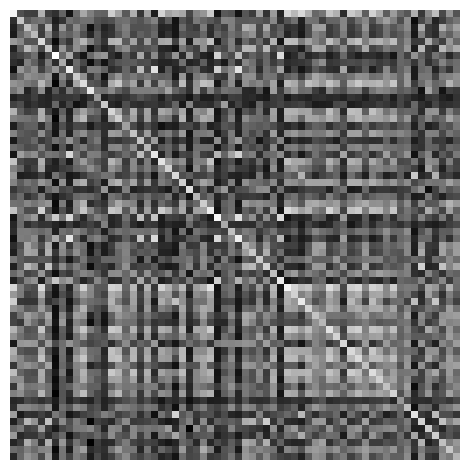

In [123]:
ts.show(tmp_ims)

# torch.topk(tmp_ims, k=2, dim=1, largest=False)[0].sum(1)
torch.sum(tmp_ims, dim=1)

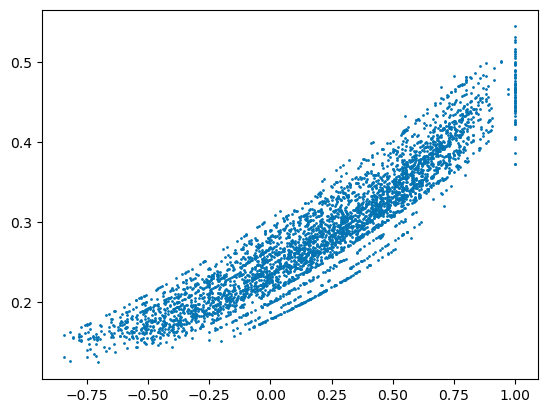

In [124]:
# inds_one

dist_array_ims = pem.normalised_softmax_distance_batch(im_enc, flatten=flatten_dist, temperature=temperature,
                                                       exclude_diag_in_denominator=True,
                                                       inner_prod_only=False)

plt.scatter(sim_im_enc, dist_array_ims.cpu().detach().numpy(), s=1)

In [127]:
# dist_array_ims
tmp_ims

tensor([[0.5254, 0.2564, 0.2307,  ..., 0.2450, 0.3680, 0.2609],
        [0.2020, 0.4484, 0.2713,  ..., 0.2275, 0.2848, 0.3166],
        [0.1778, 0.2678, 0.4440,  ..., 0.4114, 0.3293, 0.3872],
        ...,
        [0.1869, 0.2213, 0.4071,  ..., 0.4395, 0.3310, 0.3728],
        [0.3019, 0.2871, 0.3358,  ..., 0.3415, 0.4512, 0.3537],
        [0.1892, 0.2944, 0.3668,  ..., 0.3568, 0.3276, 0.4226]],
       grad_fn=<DivBackward0>)

In [128]:
tmp_pres

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [129]:
torch.sum(dist_array_ims, dim=1), im_enc.shape

(tensor([21.0748, 17.9085, 17.8690, 17.0850, 20.7752, 18.4939, 16.8366, 15.8101,
         17.7440, 19.4523, 21.7689, 18.3324, 13.0479, 14.1832, 20.1048, 20.7183,
         15.1723, 19.2625, 15.6308, 17.9433, 18.4849, 19.1860, 18.0453, 15.9817,
         20.4106, 15.8452, 16.5004, 20.2149, 21.3415, 17.8481, 13.9226, 18.0552,
         17.4922, 17.7974, 17.9436, 17.8440, 18.1542, 18.5708, 17.3396, 22.4742,
         19.7914, 19.2361, 20.3448, 19.4420, 17.6710, 21.4889, 19.9134, 18.5353,
         20.3659, 21.6211, 18.8123, 21.2139, 20.3010, 18.8371, 20.3906, 13.8351,
         18.6809, 16.5299, 17.8419, 18.1386, 17.1164, 17.0099, 19.3114, 17.6648],
        grad_fn=<SumBackward1>),
 torch.Size([64, 256]))

In [130]:
dist_array_ims.sum(0), dist_array_ims.sum(1)

(tensor([17.9561, 18.6986, 18.8092, 18.6169, 19.7264, 18.9719, 13.3618, 18.6576,
         15.3664, 19.8383, 20.4072, 16.4285, 17.3801, 14.6526, 19.4626, 20.6240,
         19.0372, 20.0451, 16.4919, 19.9796, 16.6722, 17.5562, 17.9887, 15.1677,
         20.3779, 14.7344, 18.6450, 20.2758, 18.8530, 14.7490, 16.7490, 19.3430,
         15.0502, 19.5937, 18.5440, 18.2560, 17.5975, 19.9083, 15.1713, 19.0862,
         19.5403, 17.1637, 19.9375, 20.4001, 19.6152, 19.7781, 19.5252, 17.6645,
         19.4881, 20.5345, 19.8907, 19.8167, 20.1407, 19.9573, 19.8928, 18.2781,
         20.0767, 15.0795, 17.6082, 18.4335, 17.2441, 18.1583, 19.9547, 19.7502],
        grad_fn=<SumBackward1>),
 tensor([21.0748, 17.9085, 17.8690, 17.0850, 20.7752, 18.4939, 16.8366, 15.8101,
         17.7440, 19.4523, 21.7689, 18.3324, 13.0479, 14.1832, 20.1048, 20.7183,
         15.1723, 19.2625, 15.6308, 17.9433, 18.4849, 19.1860, 18.0453, 15.9817,
         20.4106, 15.8452, 16.5004, 20.2149, 21.3415, 17.8481, 13.9226, 18.

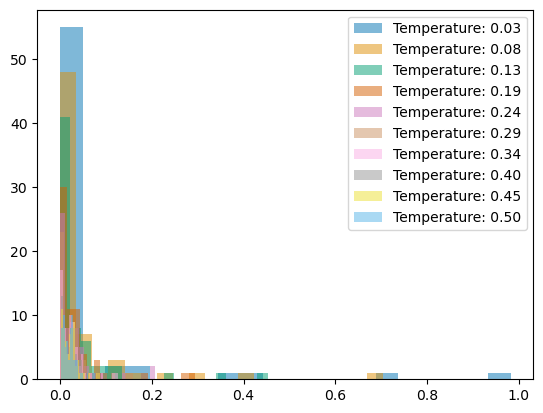

In [90]:
def create_softmax_distance_matrix(
    temperature = 0.3):
    inner = torch.tensor(sim_im_enc)
    inner = torch.exp(inner / temperature)
    sum_inner = torch.sum(inner, dim=1)
    diag = torch.diag(inner)
    sum_inner = sum_inner - diag
    sum_inner = sum_inner + 1e-8
    inner = inner / sum_inner[:, None]

    return inner[inds_one]

## plot hist as func of temp
n_temps = 10
temperatures = np.linspace(0.03, 0.5, n_temps)

for temp in temperatures:
    dist_array_ims = create_softmax_distance_matrix(temperature=temp)
    plt.hist(dist_array_ims, bins=20, alpha=0.5, label=f'Temperature: {temp:.2f}')
plt.legend()


In [51]:
torch.topk(dist_array_pres - torch.diag(dist_array_pres.diag()), k=2, largest=True, sorted=False, dim=1)[1]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

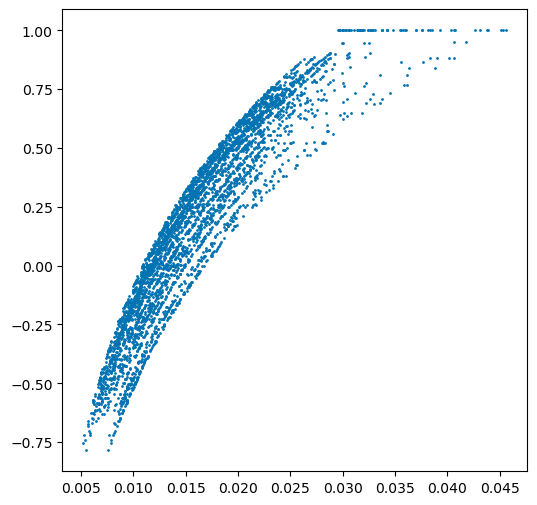

In [31]:
# dist_array_ims = dist_array_ims.cpu().detach().numpy()

plt.figure(figsize=(6,6))
# plt.scatter(dist_array_ims, dist_array_pres, s=1)
plt.scatter(dist_array_ims, sim_im_enc, s=1)

tensor([1, 5, 7, 3, 1, 4, 0, 2, 6, 5, 3, 1, 0, 0, 2, 5, 2, 1, 4, 1, 2, 2, 2, 2,
        1, 3, 1, 4, 1, 2, 1, 3, 0, 5, 1, 1, 3, 1, 0, 2, 2, 2, 2, 2, 0, 1, 0, 4,
        1, 6, 2, 1, 1, 1, 2, 4, 0, 2, 1, 0, 1, 1, 0, 2])


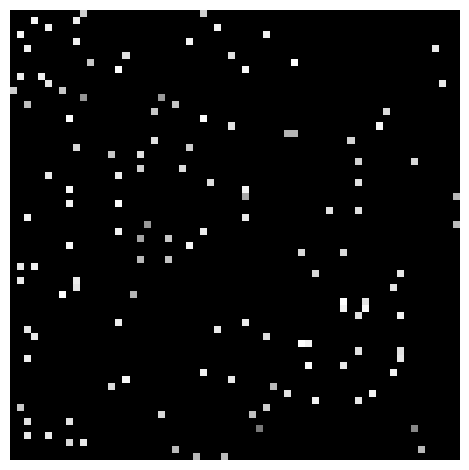

In [21]:
ts.show(dist_array_pres)
print(torch.sum(dist_array_pres > 0, 0))  ## 2 per row

In [12]:
dist_array_ims 

tensor([[0.0328, 0.0215, 0.0166,  ..., 0.0110, 0.0144, 0.0107],
        [0.0194, 0.0295, 0.0217,  ..., 0.0140, 0.0182, 0.0076],
        [0.0155, 0.0225, 0.0306,  ..., 0.0179, 0.0208, 0.0068],
        ...,
        [0.0115, 0.0163, 0.0199,  ..., 0.0342, 0.0176, 0.0107],
        [0.0143, 0.0201, 0.0222,  ..., 0.0168, 0.0327, 0.0104],
        [0.0148, 0.0116, 0.0101,  ..., 0.0142, 0.0144, 0.0453]],
       grad_fn=<DivBackward0>)